In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance,ibs,rhc_neg_logll

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter,WeibullAFTFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

import argparse

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
import os

# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)

/Users/stefanomaxenti/.pyenv/versions/3.9.13/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [3]:
dataset = "TRACE"
eps = 0.5
lr = 1e-3
sigma = 1.0
weight = 1.0
num_epochs = 150
batch_size = 512
smooth_window = 5
hidden_dims = [50, 50]


scheduler_name = "SmoothedScheduler"
scheduler_opts = "start=100, length=10"
loss_wrapper = "rhc_rank"
norm = np.inf
pareto = "0.1 0.9"

In [4]:
df_train,df_val,df_test = load_dataframe(ds_name=dataset,drop_first=True)
dataset_train, dataset_val, dataset_test = load_datasets(dataset, test_size=0.2)
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

# load the datasets
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# set the dataloader mean and std ... not needed right now
dataloader_train.mean = dataloader_val.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_val.mean = dataloader_test.std = dataset_train.std

print(f"The train dataset shape {dataset_train.tensors[0].shape}")
print(f"The val dataset shape {dataset_val.tensors[0].shape}")
print(f"The test dataset shape {dataset_test.tensors[0].shape}")

# initialize the Neural Network models (exponential models)
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

The train dataset shape torch.Size([1126, 10])
The val dataset shape torch.Size([376, 10])
The test dataset shape torch.Size([376, 10])


<All keys matched successfully>

In [5]:
epsilons = [2.0,1, .8, 0.7, .6, 0.5, 0.1, 0.07, 0.05, 0]
eps_random, ci_random= concordance(clf_robust, dataloader_train, epsilons)
df_ci_random = pd.DataFrame({"RANDOM CI":ci_random},index=eps_random)
print("Train Concordance Index RANDOM \n",df_ci_random)

eps_robust, ibs_random = ibs(clf_robust, dataloader_train, dataloader_test,epsilons)
df_ibs_random = pd.DataFrame({"RANDOM IBS":ibs_random},index=eps_robust)
print("Test Integrated Brier Score RANDOM \n",df_ibs_random)

eps_robust, neg_ll_random = rhc_neg_logll(clf_robust, dataloader_train,epsilons)
df_negll_random = pd.DataFrame({"RANDOM Neg LL":neg_ll_random},index=eps_robust)
print("Train Neg LL RANDOM \n",df_negll_random)

Train Concordance Index RANDOM 
       RANDOM CI
2.00   0.384630
1.00   0.429043
0.80   0.418518
0.70   0.418002
0.60   0.418713
0.50   0.416187
0.10   0.436319
0.07   0.439200
0.05   0.441321
0.00   0.447140
Test Integrated Brier Score RANDOM 
       RANDOM IBS
2.00    0.645103
1.00    0.614857
0.80    0.597985
0.70    0.586889
0.60    0.574042
0.50    0.559836
0.10    0.509647
0.07    0.508134
0.05    0.507290
0.00    0.505639
Train Neg LL RANDOM 
       RANDOM Neg LL
2.00  193529.421875
1.00   22213.560547
0.80   14474.747070
0.70   11725.623047
0.60    9571.118164
0.50    7937.694336
0.10    4954.622559
0.07    4901.676758
0.05    4872.600098
0.00    4816.978516


In [75]:
import torch
from tqdm import tqdm
import time
import time
from auto_LiRPA import BoundedModule, BoundedTensor
from auto_LiRPA.perturbations import *
from auto_LiRPA.utils import MultiAverageMeter
from auto_LiRPA.eps_scheduler import LinearScheduler, AdaptiveScheduler, SmoothedScheduler, FixedScheduler
import random
import numpy as np
from copy import deepcopy
from torch import optim

from src.criterion import RightCensorWrapper,ranking_loss

from csv import writer
from csv import reader

def right_censored(rate,t,event, printing=False):
    log_exact = torch.log(rate) - (t*rate)
    log_right = -(rate*t)
    if printing:
        print(log_exact, log_right)
    return (-event*log_exact - (1-event)*log_right).sum()


def pgd(model, original_data, t, event, attack_magnitude, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    original_data.to(device)
    perturbed_data = original_data
    loss = criterion
    original_images = perturbed_data.data
    
    alpha = attack_magnitude
    iters = 0
    
    for i in range(iters) : 
        model.zero_grad()

        perturbed_data.requires_grad = True
        
        #outputs = model((perturbed_data))
        cost = loss(model(perturbed_data), t, event).to(device)
        cost.backward()
        sign_gradient = perturbed_data.grad.sign()
        perturbed_data = perturbed_data.detach()
        
        perturbed_data = perturbed_data+ alpha*sign_gradient

        difference = torch.clip(perturbed_data - original_images, min=-attack_magnitude, max=attack_magnitude)
        perturbed_data = original_images+difference
    return perturbed_data
    

# TODO: customize for the right censored data analysis or exact time data analysis
def train(model,dataloader_train,optimizer,criterion,epochs,print_every=25, robust=False, save_pth=None,):
    train_loss = torch.zeros((epochs,))

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader_train, 0):
            # get the inputs; data is a list of [inputs, labels]
            xi,ti,yi = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            #print("xi:", xi)
            rate = model(xi)
            loss1 = criterion(rate,ti,yi)
            #print("pgd_r:", pgd_r)
            if robust:
                #print("rob")
                pgd_r = model(pgd(model, xi, ti, yi, 0.1, criterion))
                loss2 = criterion( pgd_r , ti, yi, printing=False)
                loss = loss1 + 0.1*loss2
            else:
                #print("non rob")
                loss = loss1
            #print(loss1, loss2)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            #print(running_loss)

        if (epoch+1) % print_every == 0:
            print("Epoch {:d}, LL={:.3f}".format(epoch+1,running_loss))
        train_loss[epoch] = running_loss

    print('Finished Training')
    if save_pth is not None:
        torch.save(model.state_dict(),save_pth)

    return torch.arange(epochs),train_loss

In [82]:
import time

clf = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims,output_dim=output_dim)
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=hidden_dims,output_dim=output_dim)

optimizer = Adam(clf.parameters(),lr=lr)
criterion = right_censored
print("Non robust")
epochs1,train_loss1 = train(model=clf,
                            dataloader_train=dataloader_train,
                            optimizer=optimizer,
                            criterion=criterion,
                            print_every=100,
                            epochs=2000)

print("Robust")
optimizer = Adam(clf_robust.parameters(),lr=lr)
criterion = right_censored
epochs2,train_loss2 = train(model=clf_robust, 
                            dataloader_train=dataloader_train,
                            optimizer=optimizer,
                            criterion=criterion,
                            print_every=100,
                            epochs=2000,
                            robust=False)

Non robust
Epoch 100, LL=1573.607
Epoch 200, LL=1546.323
Epoch 300, LL=1535.576
Epoch 400, LL=1528.174
Epoch 500, LL=1514.712
Epoch 600, LL=1502.726
Epoch 700, LL=1492.400
Epoch 800, LL=1483.564
Epoch 900, LL=1474.321
Epoch 1000, LL=1465.044
Epoch 1100, LL=1454.169
Epoch 1200, LL=1442.894
Epoch 1300, LL=1432.539
Epoch 1400, LL=1421.333
Epoch 1500, LL=1407.380
Epoch 1600, LL=1395.489
Epoch 1700, LL=1385.354
Epoch 1800, LL=1375.029
Epoch 1900, LL=1365.324
Epoch 2000, LL=1356.489
Finished Training
Robust
Epoch 100, LL=1570.348
Epoch 200, LL=1530.956
Epoch 300, LL=1515.100
Epoch 400, LL=1500.427
Epoch 500, LL=1486.154
Epoch 600, LL=1473.413
Epoch 700, LL=1462.536
Epoch 800, LL=1453.870
Epoch 900, LL=1445.068
Epoch 1000, LL=1434.655
Epoch 1100, LL=1422.585
Epoch 1200, LL=1412.037
Epoch 1300, LL=1398.842
Epoch 1400, LL=1387.400
Epoch 1500, LL=1377.919
Epoch 1600, LL=1365.795
Epoch 1700, LL=1357.029
Epoch 1800, LL=1347.443
Epoch 1900, LL=1337.534
Epoch 2000, LL=1331.431
Finished Training


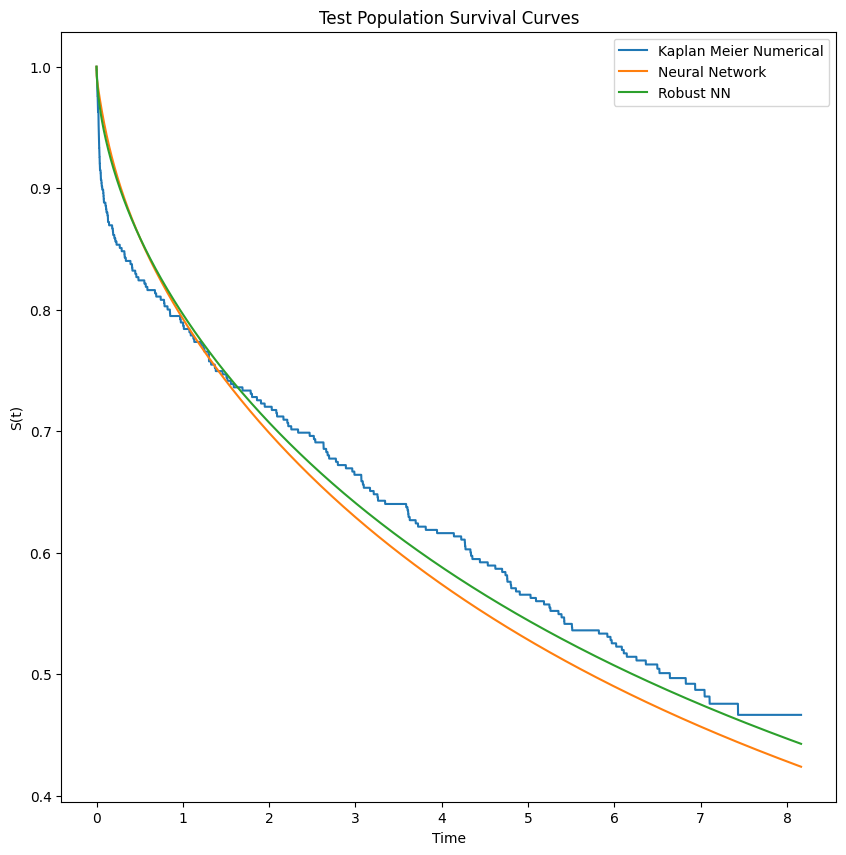

In [86]:
X_test,T_test,E_test = dataloader_test.dataset.tensors
X_test_robust = pgd(clf, X_test, T_test, E_test, 0.1, criterion)

t = torch.linspace(0,T_test.max(),10000)

St_given_x = clf.survival_qdf(X_test_robust,t).detach()
St_given_x_non_robust = clf.survival_qdf(X_test_robust,t).detach()
St_given_x_robust = clf_robust.survival_qdf(X_test_robust,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_test,event_observed=E_test)
St_kmf = kSt_kmf = kmf.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_given_x.mean(0))
plt.plot(t,St_given_x_robust.mean(0))
plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical","Neural Network", "Robust NN"])
plt.title("Test Population Survival Curves")
plt.show()